The associated codes to run this notebook can be found [here](https://github.com/prodipta/ml-finance). Clone the repo, and open this notebook (`trading/trading/notebooks/ddqn.ipynb`).

## Revisiting Q Learning

First we codify the environment. Then we create a blank Q-table with states in the rows and action in the columns. Then we follow the dynamic programming (along with all the bells and whistles of epsilon, gamma and learning rate) to update q-values to the table. For this we play the game many times, making sure we visit each cell in the table multiple times and the q-values are good approximation of expectation.

<img src="resources/q-table.png" width="50%" height="50%">

### Let's Get Real

This works for small games. But in most real life applications, it becomes quickly intractible. The number of states for most such cases can be very large. Even tic-tac-toe has a rather large number of [possible configuration](https://en.wikipedia.org/wiki/Game_complexity#:~:text=For%20tic%2Dtac%2Dtoe%2C,have%20a%20row%20of%20three.) - around 5K. For chase that number is a [whooping](https://math.stackexchange.com/questions/1406919/how-many-legal-states-of-chess-exists) 7.7∗10<sup>45</sup>. For other cases, it might be even infinite - like markets. It is impossible to visit and keep track of all states in such cases, let alone visit them multiple times for convergence.

### Functional Approximation

The approach to overcome this is to convert the Q thing from a table to a function. So instead of having a table with rows of states and columns of actions, we now have a Q function `Q(s,a)` that gives the q-value of any given state and action. 

To convert the table to a function, obviously we need some method to take the states and rewards and update the q-value. This is done by observing the states and rewards and then training a model that predicts them. Again, we start with random prediction for q-value for a given state and action. Once we step through the game and observe the actual target, we re-estimate the model so that the observed states and action combination produces the observed rewards. Once the model is trained, we can use it to predict the q-value and choose appropriate actions. In next iteration, we again retrain the model on new observations, and use prediction to choose action. Note here we are both predicting action from the model, and updating the model from realized rewards iteratively. If this process converges, we have developed a solution for large state-space problems.

### What Models We Can Use

Any `regression` model theoritically - including linear regression. However, most game can be highly non-linear (q-value depends varies in non-linear fashion with states and actions). Plus, since we are constantly training and updating the model, we need a model that can be partially trained over and again incrementally, remembering its past training. This rules out below

- we cannot use a classification model. Q-value is real-value, so it must be a regression model
- we avoid linear models to capture non-linearity
- we avoid models that cannot be retrained (like random forest)

These makes the case for artificial neural networks (`ANN`) - they can capture non-linearity and can be trained incrementally. What is more, they can be used even without fitting (although that will generate random numbers). This is required for the initial few steps when we do not have enough data and act randomly to gather experience. In fact the breakthrough in reinforcement learning - specifically Q-learning happened when Google researchers (deep mind) applied a deep neural network to a classic gaming problem. This model is known as DQN, with many other variations around it. We develop a simple variation for a trading problem. But before that, since we will use deep neural network (`DNN`), a quick intro to Keras - the interface to it that we will use

## Tensorflow and Keras

Tensorflow is one of the most popular and cutting-edge backend for DNN. At its heart, it is a computation graph specialized for DNN building, computation planning and executing those computation. Keras on the other hand is a friendly wrapper library that gives a standard Python interface to Tensorflow

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(8, input_dim=20, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(3, activation='linear'))
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 168       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 15        
Total params: 219
Trainable params: 219
Non-trainable params: 0
_________________________________________________________________


This model looks like this. We have an input layer that handles 20 features. Here the `?` signifies it can handle unspecified batch size. The inputs will be N X M dimensions, where N is the number of cases, and M is the number of features. The network only need to know the second dimension and can automatically adapt to the first. Then we build the next layer by adding another `dense` layer (which means each input nodes connect to each node in this layer) - with a node size of 8. Then another layer of size 4. The final layer is the output layer with prediction for three variables. Here the term `activation` linear means it is a regression network. For a classification network, it would could have been `softmax`. Note the other layer activation is different - `relu`. This introduces non-linearity in the network, where each of the node fires in a truncated lieanr fashion (linear between a range, no firing outside of it).

<img src="resources/model_plot.png" width="50%" height="50%">

The model that we will be using is a very similar one with a different size of the input features.

### Trading Environment

We attempt to achive a simple setup - using reinforcement learning to devise a trading strategy in a single stock. To do that, as we remember, first we have to define the trading environment. We assume an investment horizon of 20 days. During each episode, we observe the market every day. During next 20 days, we may choose to buy the stock, or if we already have bought it, can sell it off. Each day we receive a reward. It is 0 if we have no position. If we have a position, it is the total return on our holding (scaled by holding period to encourage longer holding period). After the trading horizon of 20 days the episode is reset and final reward is recorded. Let's try out a random strategy on this. The environment is already available under `trading.envs.trading_env.py`.

In [2]:
import os
import sys
import_path = os.path.abspath(os.path.join('../..'))
if import_path not in sys.path:
    sys.path.append(import_path)

In [3]:
import numpy as np
import pandas as pd
import tqdm

from trading.envs import TradingEnv

env1 = TradingEnv()
nepisodes = 100

rewards_rand = np.zeros(nepisodes)
idx = np.zeros(nepisodes, dtype=np.int64)
for i in tqdm.tqdm(range(nepisodes)):
    env1.reset()
    done = False
    while not done:
        action = np.random.randint(0,2)
        state, reward, done, extra = env1.step(action)
        if done:
            rewards_rand[i] = reward
            idx[i] = extra['date'].value

idx = pd.to_datetime(idx)
rewards_rand = pd.Series(rewards_rand, index=idx)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 88.97it/s]


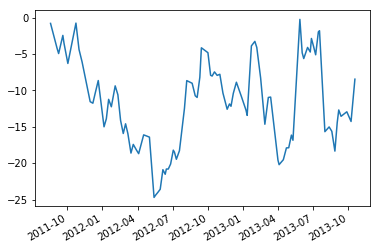

In [5]:
rewards_rand.cumsum().plot()

## Double DQN Agent

Now we develop a doule DQN (`DDQN`) agent to do better than random. As discussed before, we use a model for functional approximation of Q learning, the the model used is a `DNN`. Hence the name DQN. But we also have a `D` before.

### Why Double?

This is a variation of the original DQN (proposed later by same authors) that improves the stability of the original DQN performamce. As discussed, we are iteratively using a model to both predict actions, and then predict rewards to train itself. We need to predict reward as we are doing Q learning. And the rewards that we have observed are only part of the q-value, we also need to add the impacts for next steps. To do that we need to forecase the rewards for the next steps.

The use of same model to do both this tasks gets a bit circular, predicted rewards helps train the model and predict actions, which in turn predict rewards. This, under certain cicumstances, can be difficult to converge.

As a way around it, we use two similar, but distinct models. One we use for predicting our actions. The other we use for predicting the rewards for re-fitting our first model. From time to time, we copy the model weights from the first to the second to capture the learning of the first model. Usually, the training frequency of the first model is higher than the update frequency (copying the weights) of the second model. This gives a more stable outcome.

### Training Data - Memory Replay

Another change we do is what we call the `memory replay`. In Q-table case, we trained (updated the q-value) for each step. When we use a complex model like DNN, this can create problems. If we train the model on each new data in sequence, the correlation structure may make convergence difficult. It is like updating ourselves on each new experience, irrespective of the quality of that experience. To counter this, instead of updating with cases as and when they arrive, we simple `memorize` (store in an array) them. Then on each training epoch, we access our memory and take a random sample. We incrementally train the model **only on this sample**. This is known as `experience replay`. So with this - we can picturize the algorithm as below

<img src="resources/algo.png" width="70%" height="70%">


In [3]:
# Let's train the DDQN agent now

import numpy as np
import pandas as pd
import tqdm

from trading.envs import TradingEnv
from trading.models.dqn import Agent

env = TradingEnv()
agent = Agent(env.nstates, env.nactions)
nepisodes = 100

In [4]:
# carry out the training
rewards = agent.fit(env, nepisodes)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:51<00:00,  2.92s/it]


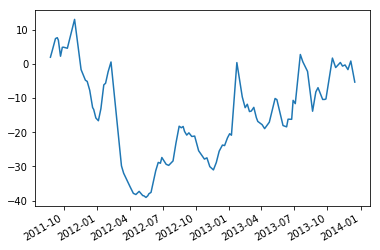

In [6]:
rewards.cumsum().plot()

We try out the agent now. Note, this is NOT the correct way of testing. The implementation has test dataset split. But here we are just simply re-running the games within the training dataset.

In [7]:
env3 = TradingEnv()
rewards_ddqn = np.zeros(nepisodes)
idx = np.zeros(nepisodes, dtype=np.int64)
for i in tqdm.tqdm(range(nepisodes)):
    env3.reset()
    done = False
    state = env3.state
    while not done:
        action = agent.act(state)
        state, reward, done, extra = env3.step(action)
        if done:
            rewards_ddqn[i] = reward
            idx[i] = extra['date'].value

idx = pd.to_datetime(idx)
rewards_ddqn = pd.Series(rewards_ddqn, index=idx)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


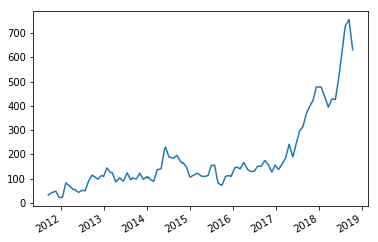

In [8]:
rewards_ddqn.cumsum().plot()

The best way to test this agent, just like the random forest example before, will be to use an event-driven backtesting (like [blueshift](https://blueshift.quantinsti.com/)). This is more so as we have a need to step through the events naturally in the problem formulation. Also this is a topy example. The results we got can be lucky (or bad-luck depending on how it turned out for you!).

Just like before, a real-life trading system will almost always have requirements that we have seen in the Random Forest examples. In addition we need

- A larger feature-set. Feeding a deep network with few features can create problems
- A carefully constructed architecture and carefully selected hyper-parameters. DNNs are much more sensitive to these
- A train-validation split during the training
- A fully event-driven backtesting for evaluation
- Also an ensemble of learners following different methods - apart from just Q - may be useful. This is important as we know the financial markets are inherently regime-shifting and an ensemble method provides stability in the face of higher variance or uncertainty
_______________________________________________________________________________________________________________________________

